# 作业4：卷积神经网络实践

本次作业将练习卷积神经网络，利用卷积层和全连接层实现手写数字的识别。

## 1. 目标

通过对 MNIST 数据进行训练，构建一个简单的图像分类模型，对图片中的数字进行识别。你将利用该模型对自己真实手写出的数字进行预测，观察模型效果。

## 2. 主要步骤

1. 获取数据
2. 定义模型结构
3. 创建模型类
4. 定义损失函数
5. 编写训练循环
6. 实施预测

### 2.1 获取数据

我们使用知名的 MNIST 数据集，它可以从 PyTorch 中利用工具函数下载得到。原始的 MNIST 数据训练集大小为60000，我们随机抽取其中的10000个观测进行简单的训练，以及10个观测进行预测展示。以下函数会在当前目录建立一个名为 data 的文件夹，其中会包含下载得到的数据集。

**注意：请在任何程序的最开始加上随机数种子的设置。请保持这一习惯。**

In [5]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

np.random.seed(123456)
torch.manual_seed(123456)

mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
loader = DataLoader(mnist, batch_size=10010, shuffle=True)

我们一次性取出随机抽取到的10010个观测，其中 x 是图片数据，y 是图片对应的数字。

In [6]:
x, y = next(iter(loader))

一个习惯性动作是查看数据的大小和维度。

In [7]:
print(x.shape)
print(y.shape)

torch.Size([10010, 1, 28, 28])
torch.Size([10010])


将最后的10张图片取为测试集：

In [8]:
xtest = x[-10:]
ytest = y[-10:]
x = x[:-10]
y = y[:-10]
print(x.shape)
print(xtest.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10, 1, 28, 28])


我们可以利用下面的函数展示图片的内容。如选择第一张测试图片，先将其转换成 Numpy 数组，再绘制图形：

(28, 28)


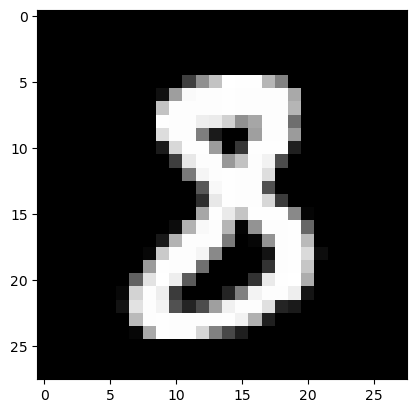

In [9]:
import matplotlib.pyplot as plt

img = xtest[0].squeeze().cpu().numpy()
print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

接下来请你选择5个你喜欢的数字（10000以下），然后取出训练集中对应位置的图片，并画出它们的内容。

img.shape:(28, 28)


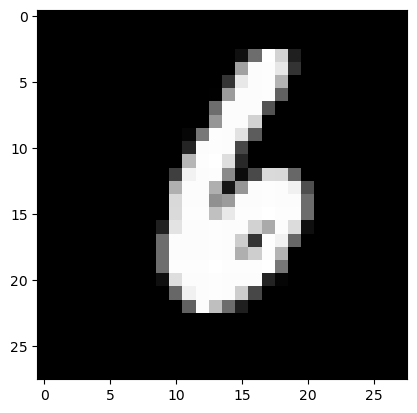

img.shape:(28, 28)


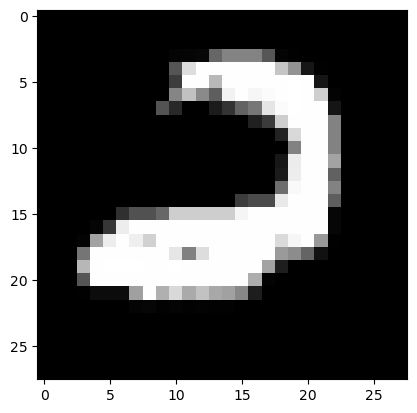

img.shape:(28, 28)


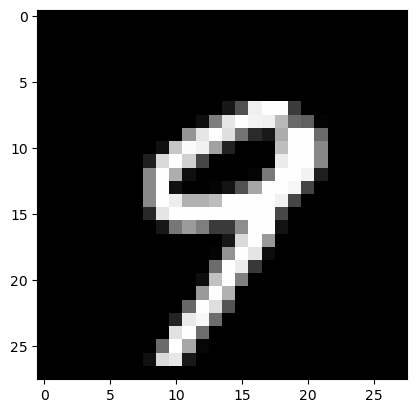

img.shape:(28, 28)


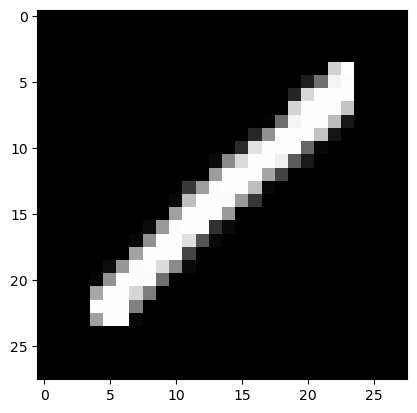

img.shape:(28, 28)


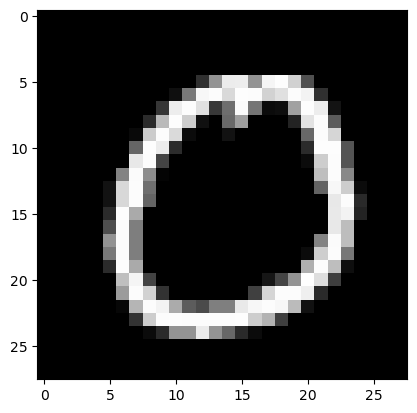

In [10]:
def show_pic(digit):
    img = digit.squeeze().cpu().numpy()
    print(f"img.shape:{img.shape}")
    plt.imshow(img,cmap='gray')
    plt.show()

show_pic(x[2])
show_pic(x[7])
show_pic(x[11])
show_pic(x[15])
show_pic(x[21])

### 2.2 定义模型结构

我们搭建一个类似于 LeNet-5 的网络，结构如下：

![](https://pic1.zhimg.com/80/v2-82eabb4c17e90d467197d013f7629f3c_720w.jpg)

我们需要创建2个卷积层、2个汇聚层和2个全连接层，**暂时忽略所有的激活函数**。所有隐藏层的函数细节都可以在[官方文档](https://pytorch.org/docs/stable/nn.html)中按分类找到。每一个隐藏层本质上都是将一个数组变换成另一个数组的函数，因此为了确认编写的模型是正确的，可以先用一个小数据进行测试，观察输入和输出的维度。例如，我们先取出前6个观测，此时输入的维度是 `[6, 1, 28, 28]`：

In [11]:
ns = 6
smallx = x[0:ns]
smally = y[0:ns]
print(smallx.shape)

print(smally.shape)

torch.Size([6, 1, 28, 28])
torch.Size([6])


接下来创建第1个卷积层，并测试输出的维度。注意到我们可以直接将隐藏层当成一个函数来调用。

In [12]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
res1 = conv1(smallx)
print(res1.shape)

torch.Size([6, 20, 24, 24])


In [13]:
def test_res(layer_fcn,layer_name, prev_res, ns, *args):
    """
    Print and assert the shape of the layer
    :param layer_fcn: current layer function (e.g. conv1,pool1)
    :param layer_name:   name of the layer (for output use)
    :param prev_res:  result of last layer (res = layer_fcn(prev_rest))
    :param ns:  sample size
    :param args:  shape of the layer
    :return: 1) Shape of the layer 2) Error when shape does not accord
    """
    result = layer_fcn(prev_res)
    print(f"Checked! Shape of [{layer_name}]:{result.shape}")
    assert result.shape == (ns,*args), f"*************** [{layer_name}] WRONG SHAPE !*****************"
    return  result

res1 = test_res(conv1,"conv1",smallx,ns,20,24,24)

Checked! Shape of [conv1]:torch.Size([6, 20, 24, 24])


可以看到，输出的维度为 `[20, 24, 24]`（不包括第1位的数据批次维度），与之前图中的结果吻合。

接下来，请按照图中提示编写层对象 `pool1`、`conv2`、`pool2`、`fc1` 和 `fc2`，并顺次测试输入与输出的维度，使其与上图匹配。注意，在将一个大小为 `[6, 50, 4, 4]` 的数组（假设叫 `somearray`）传递给 `fc1` 之前，需要先将其变形为只有两个维度的数组，做法是 `somearray.view(-1, 50*4*4)`，其中 -1 表示该位置的大小不变。

```py
pool1 = ...
res2 = pool1(res1)
print(res2.shape)
assert res2.shape == (ns, 20, 12, 12), "pool1 输出形状不对"

conv2 = ...
res3 = conv2(res2)
print(res3.shape)
assert res3.shape == (ns, 50, 8, 8), "conv2 输出形状不对"

pool2 = ...
res4 = pool2(res3)
print(res4.shape)
assert res4.shape == (ns, 50, 4, 4), "pool2 输出形状不对"

fc1 = ...
res5 = fc1(res4.view(-1, 800))
print(res5.shape)
assert res5.shape == (ns, 500), "fc1 输出形状不对"

fc2 = ...
res6 = fc2(res5)
print(res6.shape)
assert res6.shape == (ns, 10), "fc2 输出形状不对"
```

In [14]:
pool1 = torch.nn.MaxPool2d(2,stride = 2)
res2 = test_res(pool1,"Pool1",res1,ns,20,12,12)

conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50,kernel_size=5,stride=1)
res3 = test_res(conv2,"Conv2",res2,ns,50,8,8)

pool2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
res4 = test_res(pool2,"Pool2", res3, ns, 50, 4,4 )

fc1 = torch.nn.Linear(in_features=50*4*4,out_features=500)
res5 = test_res(fc1,"FC1",res4.view(-1,50*4*4),ns,500)

fc2 = torch.nn.Linear(in_features=500,out_features=10)
res6 = test_res(fc2,"FC2",res5,ns,10)


Checked! Shape of [Pool1]:torch.Size([6, 20, 12, 12])
Checked! Shape of [Conv2]:torch.Size([6, 50, 8, 8])
Checked! Shape of [Pool2]:torch.Size([6, 50, 4, 4])
Checked! Shape of [FC1]:torch.Size([6, 500])
Checked! Shape of [FC2]:torch.Size([6, 10])


### 2.3 创建模型类

在确保隐藏层维度都正确后，将所有的隐藏层封装到一个模型类中，其中模型结构在 `__init__()` 中定义，具体的计算过程在 `forward()` 中实现。此时需要加入激活函数。在本模型中，**请在 `conv1`、`conv2` 和 `fc1` 后加入 ReLU 激活函数，并在 `fc2` 后加入 Softmax 激活函数**。

```py
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ...
        self.pool1 = ...
        self.conv2 = ...
        self.pool2 = ...
        self.fc1 = ...
        self.fc2 = ...

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x) # Q: torch.relu() 和 torch.nn.Relu()有区别吗
        x = self.pool1(x)
        ...
        return x
```

In [80]:
class MyLeNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool1 = torch.nn.MaxPool2d(2,stride = 2)
        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50,kernel_size=5,stride=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = torch.nn.Linear(in_features=50*4*4,out_features=500)
        self.fc2 = torch.nn.Linear(in_features=500,out_features=10)

    def forward(self,x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)

        x = self.fc1(x.view(-1,50*4*4))
        x = torch.relu(x)

        x = self.fc2(x)
        softmax = torch.nn.Softmax(1)
        x = softmax(x)

        return  x

再次测试输入输出的维度是否正确。如果模型编写正确，输出的维度应该是 `[6, 10]`，且输出结果为0到1之间的概率值。

In [82]:
np.random.seed(123)
torch.manual_seed(123)

model = MyLeNet()
pred = model(smallx)
print(pred.shape)
print()
print(pred)
print()
print(torch.sum(pred, dim=1))

torch.Size([6, 10])

tensor([[0.0975, 0.1003, 0.0987, 0.1080, 0.0927, 0.0913, 0.0983, 0.1060, 0.1013,
         0.1058],
        [0.0971, 0.1000, 0.1006, 0.1078, 0.0939, 0.0914, 0.1014, 0.1017, 0.1025,
         0.1037],
        [0.0958, 0.0996, 0.0984, 0.1092, 0.0932, 0.0923, 0.0984, 0.1066, 0.1022,
         0.1043],
        [0.0991, 0.1006, 0.0990, 0.1091, 0.0918, 0.0889, 0.0989, 0.1061, 0.1042,
         0.1021],
        [0.0954, 0.1004, 0.1015, 0.1071, 0.0943, 0.0922, 0.1017, 0.1023, 0.1027,
         0.1024],
        [0.0962, 0.1011, 0.0987, 0.1094, 0.0923, 0.0906, 0.0958, 0.1088, 0.1024,
         0.1048]], grad_fn=<SoftmaxBackward0>)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


`pred` 的每一行加总为1，其中每一个元素代表对应类别的预测概率。

我们还可以直接打印模型对象，观察隐藏层的结构：

In [83]:
print(model)

MyLeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


### 2.4 定义损失函数

对于分类问题，损失函数通常选取为负对数似然函数。在 PyTorch 中，可以使用 `torch.nn.NLLLoss` 来完成计算。其用法是先定义一个损失函数对象，然后在预测值和真实标签上调用该函数对象。注意：损失函数对象的第一个参数是预测概率的**对数值**，第二个参数是真实的标签。[文档说明](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)。

In [84]:
lossfn = torch.nn.NLLLoss()
lossfn(torch.log(pred), smally)

tensor(2.3102, grad_fn=<NllLossBackward0>)

### 2.5 编写训练循环

利用课上介绍的循环模板和代码示例，对模型进行迭代训练。对于本数据，选取 mini-batch 大小为200，共遍历数据10遍，优化器选为 SGD，学习率为0.001。记录每个 mini-batch 下的损失函数值存放到列表 `losses_sgd` 中，然后画出损失函数的曲线。

In [ ]:
# nepoch = 30
# batch_size = 200
# lr = 0.001
#
# np.random.seed(123)
# torch.manual_seed(123)
#
# model = MyModel()
# losses = []
# opt = torch.optim.Adam(model.parameters(), lr=lr)
#
# n = x.shape[0]
# obs_id = np.arange(n)  # [0, 1, ..., n-1]
# # Run the whole data set `nepoch` times
# for i in range(nepoch):
#     # Shuffle observation IDs
#     np.random.shuffle(obs_id)
#
#     # Update on mini-batches
#     for j in range(0, n, batch_size):
#         # Create mini-batch
#         x_mini_batch = x[obs_id[j:(j + batch_size)]]
#         y_mini_batch = y[obs_id[j:(j + batch_size)]]
#         # Compute loss
#         pred = model(x_mini_batch)
#         lossfn = torch.nn.NLLLoss()
#         loss = lossfn(torch.log(pred), y_mini_batch)
#         # Compute gradient and update parameters
#         opt.zero_grad()
#         loss.backward()
#         opt.step()
#         losses.append(loss.item())
#
#         if (j // batch_size) % 20 == 0:
#             print(f"epoch {i}, batch {j // batch_size}, loss = {loss.item()}")

In [98]:
from tqdm import  tqdm
nepoch = 10
batch_size = 200
lr = 0.001

np.random.seed(123)
torch.manual_seed(123)

model = MyLeNet()
losses_sgd = []
opt = torch.optim.SGD(model.parameters(),lr=lr)

n = x.shape[0]
obs_id = np.arange(n)

for epoch in tqdm(range(nepoch)):
    np.random.shuffle(obs_id)

    for i in range(0,n,batch_size):
        # Create mini-batch
        x_mini_batch = x[obs_id[i:(i + batch_size)]]
        y_mini_batch = y[obs_id[i:(i + batch_size)]]
        # Compute loss
        pred = model(x_mini_batch)
        lossfn = torch.nn.NLLLoss()
        loss = lossfn(torch.log(pred), y_mini_batch)
        # Compute gradient and update parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses_sgd.append(loss.item())

100%|███████████████████████████████████████████| 10/10 [00:45<00:00,  4.58s/it]


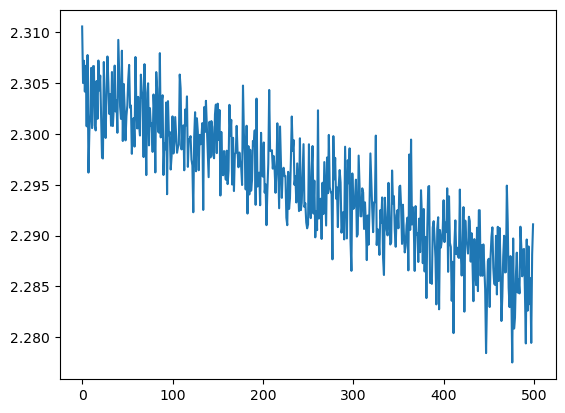

In [101]:
plt.plot(losses_sgd)
plt.show()

接下来使用 Adagrad 优化器（在[官方文档](https://pytorch.org/docs/stable/optim.html)中找到对应的函数），其他参数保持不变，重新训练一次模型，也保存下来损失函数值。

In [120]:
nepoch = 10
batch_size = 200
lr = 0.001

np.random.seed(123)
torch.manual_seed(123)

model = MyLeNet()
losses_adagrad = []


opt = torch.optim.Adagrad(model.parameters(),lr=lr)

n = x.shape[0]
obs_id = np.arange(n)

for epoch in tqdm(range(nepoch)):
    np.random.shuffle(obs_id)

    for i in range(0,n,batch_size):
        # Create mini-batch
        x_mini_batch = x[obs_id[i:(i + batch_size)]]
        y_mini_batch = y[obs_id[i:(i + batch_size)]]
        # Compute loss
        pred = model(x_mini_batch)
        lossfn = torch.nn.NLLLoss()
        loss = lossfn(torch.log(pred), y_mini_batch)
        # Compute gradient and update parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses_adagrad.append(loss.item())
# 完成模型训练

100%|███████████████████████████████████████████| 10/10 [01:02<00:00,  6.23s/it]


对比 SGD 和 Adagrad，画出各自的损失函数曲线。

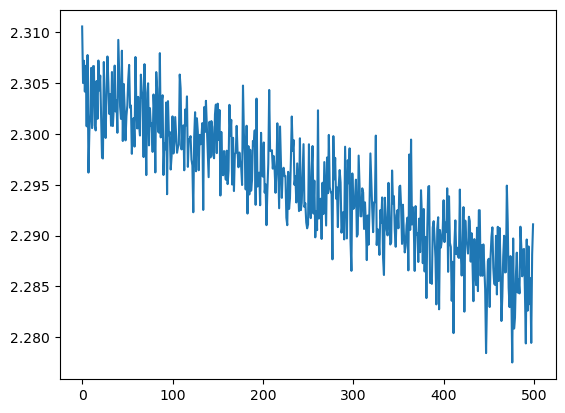

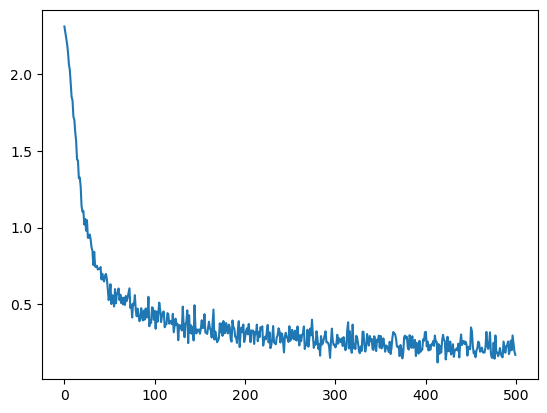

In [105]:
plt.plot(losses_sgd)
plt.show()
plt.plot(losses_adagrad)
plt.show()

最后再自行选择一款优化器，重复上面的实验，并画出三种优化器的损失函数值对比图。

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.25it/s]


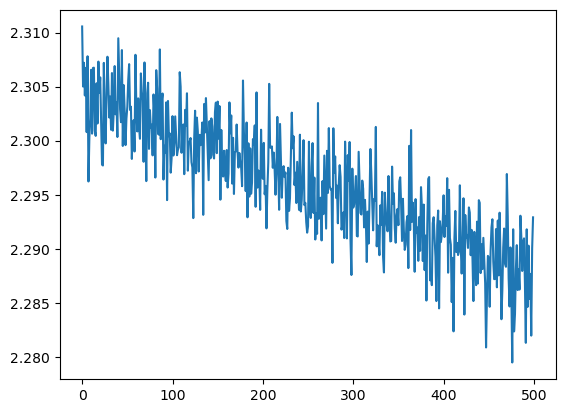

In [117]:
nepoch = 10
batch_size = 200
lr = 0.001

np.random.seed(123)
torch.manual_seed(123)

model = MyLeNet()

losses_adadelta = []


opt = torch.optim.Adadelta(model.parameters(),lr=lr)

n = x.shape[0]
obs_id = np.arange(n)

for epoch in range(nepoch):
    np.random.shuffle(obs_id)

    for i in tqdm(range(0,n,batch_size)):
        # Create mini-batch
        x_mini_batch = x[obs_id[i:(i + batch_size)]]
        y_mini_batch = y[obs_id[i:(i + batch_size)]]
        # Compute loss
        pred = model(x_mini_batch)
        lossfn = torch.nn.NLLLoss()
        loss = lossfn(torch.log(pred), y_mini_batch)
        # Compute gradient and update parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses_adadelta.append(loss.item())

plt.plot(losses_adadelta)
plt.show()
# 完成模型训练和作图

### 2.6 实施预测

为了验证模型的效果，我们对10个测试观测（即之前生成的 `testx`）进行预测。

In [121]:
ypred = model(xtest)
print(np.round(ypred.detach().cpu().numpy(), 3))
print(ytest)

[[0.    0.    0.044 0.207 0.    0.002 0.    0.    0.747 0.   ]
 [0.011 0.    0.02  0.005 0.001 0.016 0.    0.171 0.003 0.772]
 [0.001 0.    0.506 0.488 0.    0.002 0.001 0.    0.001 0.   ]
 [0.    0.    0.999 0.001 0.    0.    0.    0.    0.    0.   ]
 [0.    0.994 0.001 0.001 0.    0.001 0.    0.001 0.001 0.   ]
 [0.002 0.085 0.048 0.086 0.046 0.511 0.007 0.09  0.034 0.09 ]
 [0.038 0.001 0.06  0.007 0.002 0.013 0.081 0.001 0.772 0.026]
 [0.    0.    0.    0.001 0.06  0.002 0.    0.019 0.006 0.913]
 [0.    0.    0.001 0.    0.    0.002 0.    0.    0.994 0.003]
 [0.    0.    0.    0.    0.    0.    0.    0.999 0.    0.001]]
tensor([8, 9, 2, 2, 1, 5, 0, 9, 8, 7])


如果模型搭建和训练都正常，那么每一行中概率最大的取值所在的位置应该正好对应真实的标签。我们也可以让 PyTorch 自动找到最大值的位置。

In [122]:
torch.argmax(ypred, dim=1)

tensor([8, 9, 2, 2, 1, 5, 8, 9, 8, 7])

最后，我们用模型对一些真实的手写数字图片进行预测。请你利用绘图软件（如 Windows 自带的绘图，或 Photoshop 等）准备10张正方形黑色底色的图片，每张用鼠标绘制一个数字（请使用较粗的笔划），从0到9，然后以0.png，1.png等文件名存储下来，放到当前目录一个名为 digits 的文件夹中。以下是几个例子：
![](digits/sample0.png) ![](digits/sample5.png) ![](digits/sample8.png)

接下来利用 Pillow 软件包读取图片：

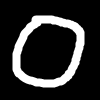

In [133]:
from PIL import Image
im = Image.open("/Users/xinby/Desktop/ByCsdiy/DeepLearning/DeepLearning_Qyx/HW4/digits/sample0.png")
im

此时如果直接将其转为 Numpy 数组会得到三个通道：

In [134]:
im_arr = np.array(im)
print(im_arr.shape)

(100, 100, 3)


因此，我们先强制转换为灰度图片（单通道），再缩放至模型的图片大小 28 x 28：

In [135]:
im = im.convert("L")
im.thumbnail((28, 28))
im_arr = np.array(im)
print(im_arr.shape)
im

(28, 28)


为了传递给模型对象，还需要先将数值归一化到 [0,1] 区间，转换为 PyTorch 的 Tensor 类型，并增加一个批次和一个通道的维度：

In [136]:
test0 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
print(test0.shape)

torch.Size([1, 1, 28, 28])


最后对图片标签进行预测：

In [137]:
pred0 = model(test0)
print(np.round(pred0.detach().cpu().numpy(), 3))
print(*torch.argmax(pred0, dim=1))

[[0.867 0.    0.024 0.039 0.    0.069 0.    0.    0.001 0.   ]]
tensor(0)


预测结果是否符合真实情形？请对你自己绘制出的10张图片进行类似的预测操作，并评价其效果。

In [164]:
import os

def digit_pred(image_path):
    im = Image.open(image_path)
    im_arr = np.array(im)
    im = im.convert("L")
    im.thumbnail((28, 28))
    im_arr = np.array(im)
    test = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
    pred = model(test)
    prob = np.round(pred.detach().cpu().numpy(),3)
    maxprob = np.max(prob)
    print(f"Predicted :{np.argmax(prob)} with Prob:{maxprob}")

for filepath in os.walk(r"/Users/xinby/Desktop/ByCsdiy/DeepLearning/DeepLearning_Qyx/HW4/digits"):
    print(*filepath)

/Users/xinby/Desktop/ByCsdiy/DeepLearning/DeepLearning_Qyx/HW4/digits [] ['sample8.png', 'sample5.png', 'sample0.png']
